In [2]:
from scipy.special import sph_harm as sph
import astropy.io.fits as pf
from math import sqrt, pi
import healpy as hp
import numpy as np
import time
NSIDE = 32
numPix = hp.nside2npix(NSIDE)
Nmax = int(2*sqrt(hp.nside2npix(NSIDE)))
print(f"For NSIDE = {NSIDE}, numPix = {numPix}, Nmax = int(1.5*sqrt(numPix)) = {Nmax}")
%matplotlib notebook

For NSIDE = 32, numPix = 12288, Nmax = int(1.5*sqrt(numPix)) = 221


In [3]:
def make_map(theta, phi, data, NSIDE):
    """
    Makes healPy map given the map values on grid points and the grid coordinates.
    ==========================================================
    Inputs: (theta, phi, data, NSIDE)
    ----------------------------------------------------------
    theta - coordinate 1
    phi   - coordiante 2
    data  - value of map at [coordinate 1, coordinate 2]
    NSIDE - the NSIDE for the output healPy map
    ==========================================================
    Outputs: (map, mask, theta, phi)
    ----------------------------------------------------------
    map   - the healPy map 
    mask  - mask which contains information about missing data
    theta - coordinate 1 (healPy format)
    phi   - coordinate 2 (healPy format)
    ==========================================================
    plt.figure()
    plt.subplot(211)
    plt.imshow(theta)
    
    plt.subplot(212)
    plt.imshow(phi)
    plt.show()
    """
    
    theta = theta.flatten()
    phi = phi.flatten()
    data = data.flatten()
    # checking if the input data is compatible
    assert len(theta) == len(phi) == len(data)
    
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    
    # creating map, mask, theta, phi, count arrays
    e1map = np.full(_numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(_numPix, False, dtype=np.bool)
    counts = np.ones(_numPix, dtype=np.int) # used for averaging pixel data
    
    for i, k in enumerate(data):
        _index = hp.ang2pix(NSIDE, theta[i], phi[i])
        if not existance[_index]:
            e1map[_index] = 0
            counts[_index] = 0
            existance[_index] = True
        e1map[_index] += k
        counts[_index] += 1
    print(f"Making healPy maps -- Complete")
    return e1map/counts, existance

def random_map_healpy(NSIDE):
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    rmap = np.random.rand(_numPix, dtype=np.float) - 0.5
    return rmap

def random_map_uniform(Nmax):
    return 100*(np.random.rand(Nmax, Nmax) - 0.5)

In [1]:
def rotate_map_spin(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
    ct, cp, st, sp = np.cos(t), np.cos(p), np.sin(t), np.sin(p)
    vt = np.array([ct*cp, ct*sp, -st])
    vp = np.array([-sp, cp, 0.0])
    

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    ctR, cpR, stR, spR = np.cos(trot), np.cos(prot), np.sin(trot), np.sin(prot)
    vtR = np.array([ctR*cpR, ctR*spR, -stR])
    vpR = np.array([-spR, cpR, 0.0])

    # Interpolate map onto these co-ordinates
    rot_map0temp = hp.get_interp_val(hmap[0], trot, prot)
    rot_map1temp = hp.get_interp_val(hmap[1], trot, prot)
    
    rot_map0 = (vt*vpR).sum(axis=0) * rot_map0temp + (vp*vpR).sum(axis=0) * rot_map1temp
    rot_map1 = (vt*vtR).sum(axis=0) * rot_map0temp + (vp*vtR).sum(axis=0) * rot_map1temp

    return rot_map0, rot_map1

def rotate_map_spin_eul(hmap, eulAngle):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap[0]))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
    ct, cp, st, sp = np.cos(t), np.cos(p), np.sin(t), np.sin(p)
    vt = np.array([ct*cp, ct*sp, -st])
    vp = np.array([-sp, cp, 0.0*cp])
    
    # Define a rotator
    r = hp.rotator.Rotator(eulAngle, deg=False, eulertype='zxz')

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    ctR, cpR, stR, spR = np.cos(trot), np.cos(prot), np.sin(trot), np.sin(prot)
    vtR = np.array([ctR*cpR, ctR*spR, -stR])
    vpR = np.array([-spR, cpR, 0.0*cpR])
    rotMat = R.from_euler('zxz', eulAngle).as_dcm()
    vtR = vtR.transpose().dot(rotMat).transpose()
    vpR = vpR.transpose().dot(rotMat).transpose()

    # Interpolate map onto these co-ordinates
    rot_map0temp = hp.get_interp_val(hmap[0], trot, prot)
    rot_map1temp = hp.get_interp_val(hmap[1], trot, prot)
    
    rot_map0 = (vt*vpR).sum(axis=0) * rot_map0temp + (vp*vpR).sum(axis=0) * rot_map1temp
    rot_map1 = (vt*vtR).sum(axis=0) * rot_map0temp + (vp*vtR).sum(axis=0) * rot_map1temp

    return rot_map0, rot_map1


def rotate_map(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap[0]))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

In [2]:
def restructure(ellArr, emmArr, lmax, coefs):
    """
    Restructures the alms into the format compatible with pleg
    
    i.e. newCoefs[0] corresponds to ell = 0, emm = 0
         newCoefs[1] corresponds to ell = 1, emm = 0
         newCoefs[2] corresponds to ell = 1, emm = 1
         newCoefs[3] corresponds to ell = 2, emm = 0
         newCoefs[4] corresponds to ell = 2, emm = 1 
         newCoefs[5] corresponds to ell = 2, emm = 2
         ..... and so on
    
    ===========================================================
    Inputs: (ellArr, emmArr, lmax, coefs)
    -----------------------------------------------------------
    ellArr  - array with ell corresponding to alms
    emmArr  - array with m corresponding to alms
    lmax    - maximum value of ell
    coefs   - alms
    ===========================================================
    Outputs: (newCoefs)
    -----------------------------------------------------------
    newCoefs - new alms in the format compatible with pleg
    ===========================================================
    
    """
    count = 0
    newCoefs = np.zeros(coefs.shape[0], dtype=complex)
    for ell in range(lmax):
        for emm in range(ell+1): 
            index = np.where( (ellArr==ell) * (emmArr==emm) )[0][0]
            newCoefs[count] = coefs[index]
            count += 1
    return newCoefs

### Creating a synthetic map
We first create a synthetic map where $f(\theta, \phi) = \sum_{l=0}^{lmax} \sum_{m=-l}^l r_{lm} Y_{lm}(\theta, \phi)$, where $r_{lm}$ is a random coefficient. Two such maps are created. One with half disk and one with full disk data. These synthetic maps are band limited, by design. Synthetic maps have only $m \ge 0$ features.

For testing rotation of spherical harmonics, we create a maps for each of $\hat{r}, \hat{\theta}, \hat{\phi}$ components. The $\hat{r}$ map contains a bunch of randomly generated values $\to$ This is denoted by map_r. The $\hat{\theta}$ map contains meridional circulation. We do this by using $ v_{20}, v_{40} $ components $\to$ map_t. The $\hat{\phi}$ map contains differential rotation. We generate this by using $ w_{10}, w_{30} $ components $\to$ map_p.

In [ ]:
# parameters for the synthetic map
lmaxSynth = 8 # maximum ell for the radial map
maxNum = int((lmaxSynth+1)*(lmaxSynth+2)/2)
almSynth = np.zeros(maxNum)
ellSynth = np.zeros(maxNum)

Nmax = 40
theta = np.linspace(0, pi - 1e-4, Nmax).reshape(Nmax, 1)
phi = np.linspace(-pi/2 + 1e-4, pi/2 - 1e-4, Nmax).reshape(1, Nmax)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta) * np.ones(phi.shape)
PHIROT = np.arctan2(z, y)
THETAROT = np.arcsin(np.sqrt( y**2 + z**2 ))
PHI, THETA = np.meshgrid(phi, theta)

count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        if ell==0 and emm==0:
            almSynth[count] = (np.random.rand() - 0.5)*ell
            ellSynth[count] = ell
            map0 = almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
        else:
            almSynth[count] = (np.random.rand() - 0.5)*ell
            ellSynth[count] = ell
            map0 += almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
# giving the synthetic maps some rotation+MC features
#map0 += 2000*sph(0, 1, phi, theta) + 200*sph(0, 3, phi, theta) + 20*sph(0, 5, phi, theta) +  150*sph(0, 2, phi, theta) + 15*sph(0, 60, phi, theta)
print("r-component -- complete")

map1 = sph(0, 2, phi, theta) + 0.2*sph(0, 4, phi, theta) #map for theta component
map2 = sph(0, 1, phi, theta) + 0.15*sph(0, 3, phi, theta) #map for phi component
print("t-component -- complete")
print("p-component -- complete")

ps0 = np.zeros(lmaxSynth)
for ell in range(lmaxSynth):
    maskEll = ellSynth==ell
    ps0[ell] = (abs(almSynth[maskEll])**2).sum()*2/(2*ell+1)
ellSynthArr = np.arange(lmaxSynth)

### Testing for scalar spherical harmonics
- First we create a map with random values, P0 as pole - map0
- Obtain alms for map0 - alm0
- Create same map with P1 as pole - map1
- Obtain alms for map1 - alm1
- Rotate alm0 - alm01
- Check if alm01==alm1

Nmax = 221


<IPython.core.display.Javascript object>


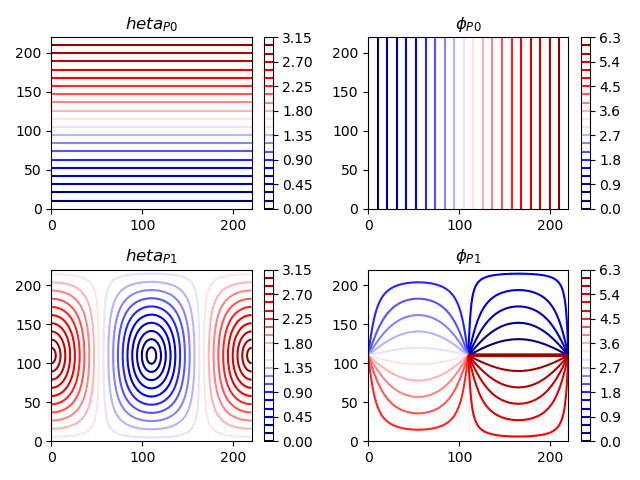

 theta1.min = 3.1830988618379067e-13, theta0.max = 0.9999999999996817
 phi0.min = 3.1830988618379067e-13, phi0.max = 1.9999999999996816
 theta1.min = 0.0, theta1.max = 0.9999999999996817
 phi1.min = 0.004545454545451602, phi1.max = 2.0


In [6]:
# theta0, phi0 correspond to coordinates with P0 as the pole
print(f"Nmax = {Nmax}")
theta0 = np.linspace(1e-12, pi - 1e-12, Nmax).reshape(Nmax, 1)
phi0 = np.linspace(1e-12, 2*pi - 1e-12, Nmax).reshape(1, Nmax)
y = np.sin(theta0) * np.sin(phi0)
x = np.sin(theta0) * np.cos(phi0)
z = np.cos(theta0) * np.ones(phi0.shape)

# theta1, phi1 correspond to coordinates with P1 as the pole
phi1 = np.arctan2(z, y) + pi
r = np.sqrt(y**2 + z**2)
r[r>1] = 1
theta1 = np.arcsin( r ) # has values only between 0 and pi/2
maskXP = x>0
theta1[~maskXP] = pi - theta1[~maskXP]
theta1 = pi - theta1

theta0G = theta0 * np.ones(phi0.shape)
phi0G = phi0 * np.ones(theta0.shape)
# checking if the generated coordinates are ok
plt.figure()

plt.subplot(221)
im = plt.contour(theta0G, 20, cmap='seismic')
plt.colorbar(im)
plt.title('$ \theta_{P0}$')

plt.subplot(222)
im = plt.contour(phi0G, 20, cmap='seismic')
plt.colorbar(im)
plt.title('$ \phi_{P0}$')

plt.subplot(223)
im = plt.contour(theta1, 20, cmap='seismic')
plt.colorbar(im)
plt.title('$ \theta_{P1}$')

plt.subplot(224)
im = plt.contour(phi1, 20, cmap='seismic')
plt.colorbar(im)
plt.title('$ \phi_{P1}$')

plt.tight_layout()
plt.show()

print(f" theta1.min = {theta0.min()/pi}, theta0.max = {theta0.max()/pi}")
print(f" phi0.min = {phi0.min()/pi}, phi0.max = {phi0.max()/pi}")
print(f" theta1.min = {theta1.min()/pi}, theta1.max = {theta1.max()/pi}")
print(f" phi1.min = {phi1.min()/pi}, phi1.max = {phi1.max()/pi}")

22

/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


Making healPy maps -- Complete
Making healPy maps -- Complete
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


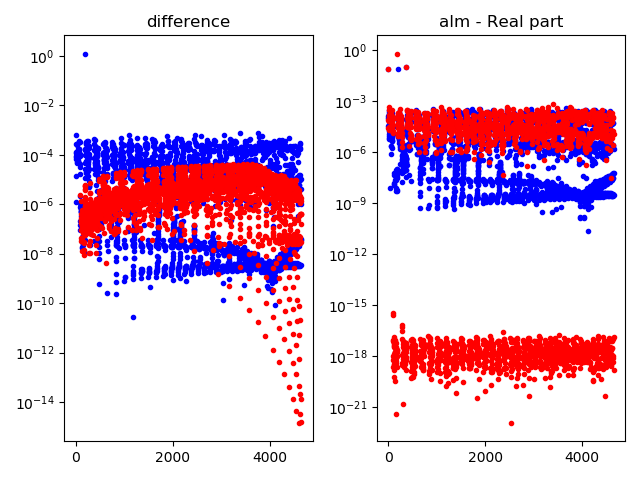

In [7]:
#map0u = random_map_uniform(Nmax)
map0u = sph(0, 2, phi0, theta0) + 0.2*sph(0, 4, phi0, theta0) #map for theta component
map0, _mask0 = make_map(theta0G, phi0G, map0u, NSIDE)
map1, _mask1 = make_map(theta1, phi1, map0u, NSIDE)
alm0 = hp.map2alm(map0)
alm1 = hp.map2alm(map1)
alm01 = alm0.copy()
hp.rotate_alm(alm01, psi=0.0, theta=-pi/2, phi=0.0)
map01 = hp.alm2map(alm01, NSIDE)
#hp.rotate_alm(alm01, psi=0.0, theta=pi/2, phi=0.0)
diff = alm01 - alm1

plt.figure()
plt.subplot(121)
plt.semilogy(diff.real, '.b')
plt.semilogy(diff.imag, '.r')
plt.title("difference")

plt.subplot(122)
plt.semilogy(alm1.real, '.b')
plt.semilogy(alm01.real, '.r')
plt.title("alm - Real part")

plt.tight_layout()
plt.show()

In [9]:
map2 = rotate_map(map0, pi/2, 0)

map shape = (221, 221)


<IPython.core.display.Javascript object>


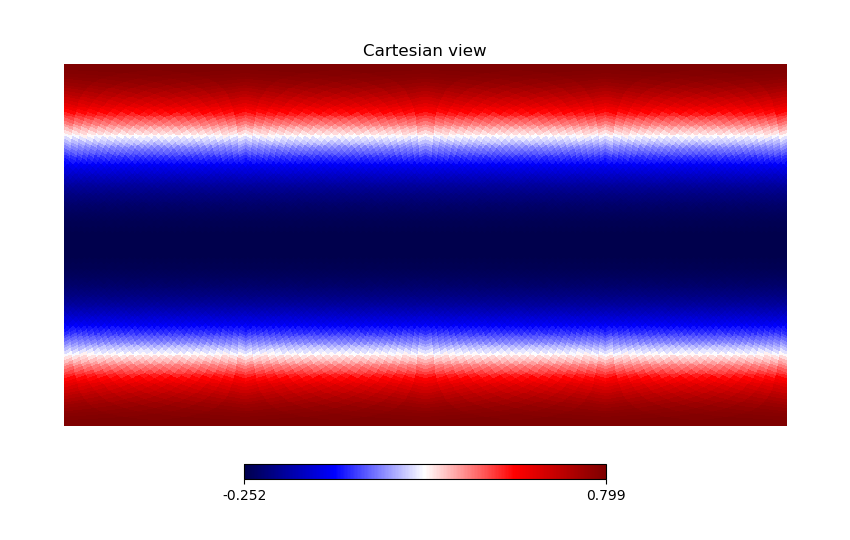

<IPython.core.display.Javascript object>


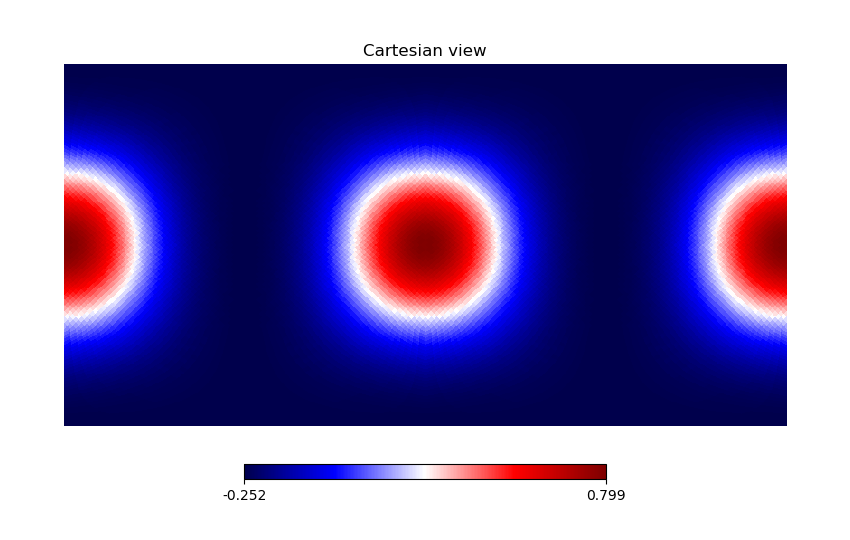

<IPython.core.display.Javascript object>


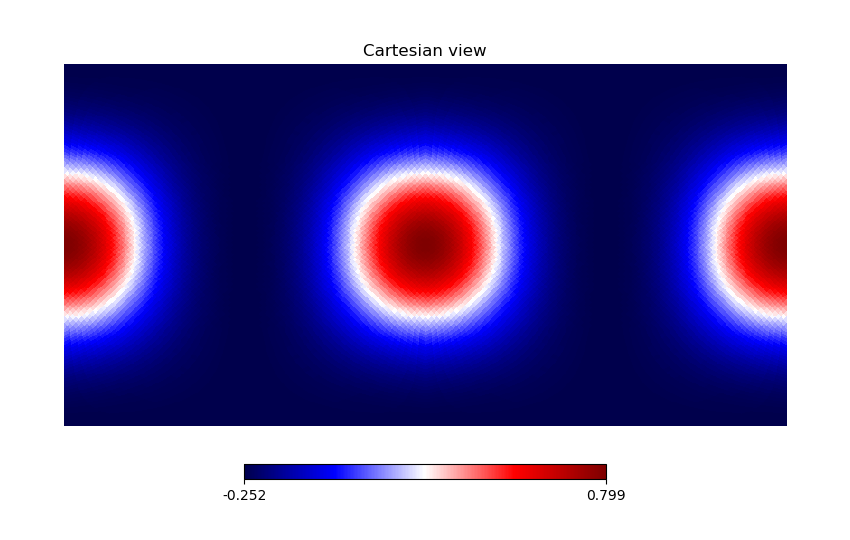

In [12]:
print(f"map shape = {map0u.shape}")
hp.cartview(map0, cmap='seismic')
hp.cartview(map01, cmap='seismic')
hp.cartview(map2, cmap='seismic')

In [ ]:
print(f"Range of THETA = ({THETA.min()}, {THETA.max()})")
print(f"Range of PHI = ({PHI.min()}, {PHI.max()})")
print(f"Range of THETAROT = ({THETAROT.min()}, {THETAROT.max()})")
print(f"Range of PHIROT = ({PHIROT.min()}, {PHIROT.max()})")
tempmask = np.sqrt( y**2 + z**2 ) > 1
print(f"count = {tempmask.sum()}")
del tempmask
plt.figure()
plt.subplot(121)
im = plt.contour(THETAROT, 12, cmap='seismic')
plt.colorbar(im)

plt.subplot(122)
im = plt.contour(PHIROT, 12, cmap='seismic')
plt.colorbar(im)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


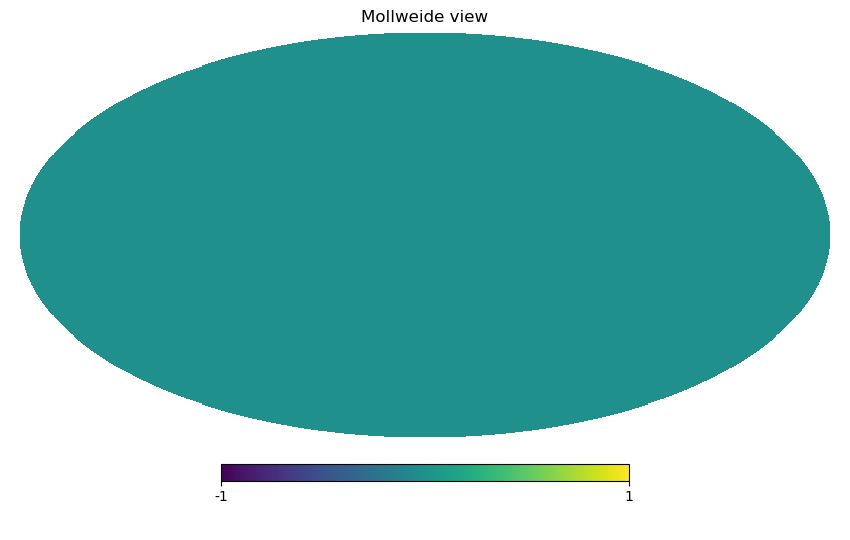

In [ ]:
def pow_alm(ipmap):
    power = hp.sphtfunc.anafast(ipmap)
    alm = hp.sphtfunc.map2alm(ipmap)
    return power, alm

# Making the healPy maps
map_r, mask_r, theta, phi = make_map(THETA.flatten(), PHI.flatten(), map0.flatten(), NSIDE)
map_t, mask_t, theta, phi = make_map(THETA.flatten(), PHI.flatten(), map1.flatten(), NSIDE)
map_p, mask_p, theta, phi = make_map(THETA.flatten(), PHI.flatten(), map2.flatten(), NSIDE)
map_rRot, mask_rRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map0.flatten(), NSIDE)
map_tRot, mask_tRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map1.flatten(), NSIDE)
map_pRot, mask_pRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map2.flatten(), NSIDE)

In [ ]:
hp.mollview(map_r, cmap='seismic')
map_rRot, mask_rRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map0.flatten(), NSIDE)
hp.mollview(map_rRot, cmap='seismic')

# Computing the alms using healPy functions
power_r, alm_r = pow_alm(map_r)
power_t, alm_t = pow_alm(map_t)
power_p, alm_p = pow_alm(map_p)

# Computing the alms-spin1 using healPy functions
nside = NSIDE
npix = hp.nside2npix(nside)
ipix = np.arange(npix)
theta_p1, phi_p1 = hp.pix2ang(nside, ipix)

lr_p1 = np.cos(theta_p1)
lt_p1 = -np.sin(theta_p1)
lr_p1[~mask_r] = 0.0
lt_p1[~mask_r] = 0.0

hp.mollview(lr_p1, cmap='seismic')

In [ ]:
theta.shape

In [ ]:
nside = NSIDE
npix = hp.nside2npix(nside)
ipix = np.arange(npix)
#theta, phi = hp.pix2ang(nside, ipix)

lr = np.cos(theta)
lt = -np.sin(theta)

apod = 1.0#/(1 + np.exp(35*(thetaMapRot - np.pi/2.3)))
map_0 = mapFull * lr * apod
map_p1 = - mapFull * lt / sqrt(2) * apod
map_m1 = - mapFull * lt / sqrt(2) * apod
#map_trans = [(map_p1 + map_m1)/2, -1j*(map_p1 - map_m1)/2]
map_trans = [map_p1, 0.0*map_p1]
map_0[~maskFull] = hp.UNSEEN
map_trans[0][~maskFull] = 0.0#hp.UNSEEN
map_trans[1][~maskFull] = 0.0#hp.UNSEEN
alm_r = hp.map2alm(map_0)
alm_pm = hp.map2alm_spin(map_trans, 1)
alm_v, alm_w = alm_pm[0], alm_pm[1]
alm_p = alm_pm[0]
alm_m = alm_pm[1]
alm_vRot = -alm_p
alm_wRot = -1j*alm_m


alm2r = alm_r.copy()
alm2p = alm_p.copy()
alm2m = alm_m.copy()
hp.rotate_alm(alm2r, psi=0.0, theta=-pi/2, phi=0.0)
#hp.rotate_alm(alm2r, psi=0.0, theta=pi/2, phi=0.0)
hp.rotate_alm(alm2p, psi=0.0, theta=pi/2, phi=0.0)
hp.rotate_alm(alm2m, psi=0.0, theta=pi/2, phi=0.0)
map2 = hp.alm2map(alm2r, 32)
hp.mollview(map_0, cmap='seismic')
hp.mollview(map2, cmap='seismic')